In [25]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer

In [26]:
df=pd.read_csv('age_gender.csv')

In [27]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


### Pipeline Formation 

In [28]:
# Séparer les variables indépendantes (X) de la variable cible (y)
X = df[['pixels']]
y = df["age"]

In [29]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.2,random_state=42)

In [30]:
# Définir les colonnes nécessitant une normalisation
pixels_cols=['pixels']

In [31]:
def preprocess_images(images):
    if isinstance(images, pd.Series):
        # Convertir la chaîne de pixels en tableau numpy et le redimensionner
        pixels_array = np.array(images.str.split().tolist(), dtype=np.float32)  # Ne pas redimensionner ici
    else:
        # Convertir la chaîne de pixels en tableau numpy et le redimensionner
        pixels_array = np.array(images['pixels'].str.split().tolist(), dtype=np.float32)  # Ne pas redimensionner ici
    # Normaliser les valeurs des pixels entre 0 et 1 si nécessaire
    if np.max(pixels_array) > 1:
        pixels_array = pixels_array / 255.0
    return pixels_array

# Créer une instance de FunctionTransformer avec la fonction preprocess_image
image_preprocessor = FunctionTransformer(preprocess_images)

In [32]:
from sklearn.preprocessing import FunctionTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('pixels', image_preprocessor, pixels_cols)  # Normaliser la variable pixels
    ])

In [33]:
# Créer le pipeline avec le préprocesseur et le modèle Decison Tree
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())  # Votre modèle de régression Ridge
])

# Définir les paramètres à optimiser pour Ridge
params = {'regressor__alpha': [10,15,20], 'regressor__solver': ['auto', 'svd']}

# Créer un objet GridSearchCV avec votre pipeline et les paramètres à optimiser
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

### Fit & Predict

In [34]:
# Entraîner le modèle
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pixels',
                                                                         FunctionTransformer(func=<function preprocess_images at 0x7f6870d9ba60>),
                                                                         ['pixels'])])),
                                       ('regressor', Ridge())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [10, 15, 20],
                         'regressor__solver': ['auto', 'svd']},
             scoring='neg_mean_squared_error')

In [35]:
# Afficher les meilleurs paramètres et la meilleure performance
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure MSE:", -grid_search.best_score_)

Meilleurs paramètres: {'regressor__alpha': 20, 'regressor__solver': 'svd'}
Meilleure MSE: 199.81712114559286


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prédire les valeurs sur les données d'entraînement et de test
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Calculer le MAE et le RMSE pour les données d'entraînement et de test
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# Afficher les résultats
print("MAE sur les données d'entraînement:", train_mae)
print("RMSE sur les données d'entraînement:", train_rmse)
print("MAE sur les données de test:", test_mae)
print("RMSE sur les données de test:", test_rmse)

MAE sur les données d'entraînement: 10.026308123961302
RMSE sur les données d'entraînement: 12.994563652142832
MAE sur les données de test: 10.591709700195983
RMSE sur les données de test: 13.83220896468622


/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Feature importance

In [37]:
# Extraire le modèle Ridge du pipeline
ridge_model = grid_search.best_estimator_.named_steps['regressor']

# Extraire les coefficients du modèle Ridge
coefficients = ridge_model.coef_

# Associer les coefficients aux noms des features
coefficients_dict = dict(zip(X_train.columns, coefficients))

# Afficher les coefficients dans l'ordre décroissant d'importance
sorted_coefficients = sorted(coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"Feature: {feature}, Coefficient: {coef}")


Feature: pixels, Coefficient: 4.007681846618652


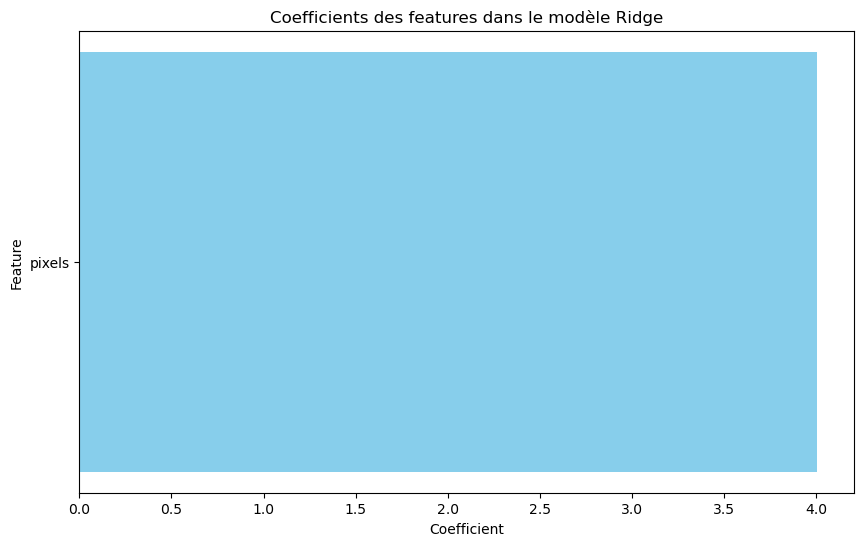

In [38]:
# Extraire les noms des features et les coefficients
features = [feature for feature, coef in sorted_coefficients]
coefficients = [coef for feature, coef in sorted_coefficients]

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients des features dans le modèle Ridge')
plt.gca().invert_yaxis()  # Inverser l'ordre des features sur l'axe y
plt.show()

#### Explination Of results (train & test)

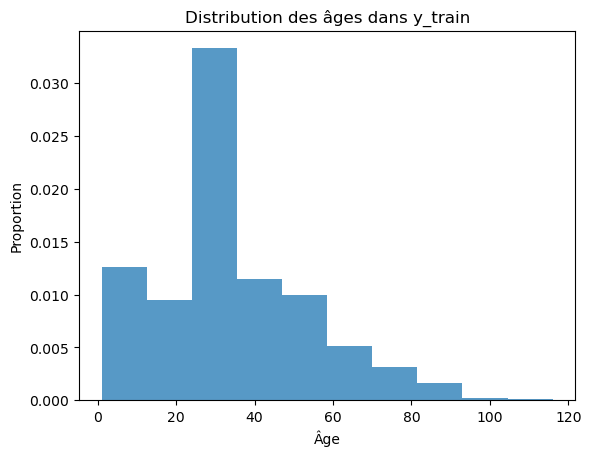

In [39]:
# Créer une figure et un axe
fig, ax = plt.subplots()
# Tracer l'histogramme des âges
ax.hist(y_train, bins=10, density=True, alpha=0.75)

# Ajouter des titres et des étiquettes d'axe
ax.set_title('Distribution des âges dans y_train')
ax.set_xlabel('Âge')
ax.set_ylabel('Proportion')

# Afficher le graphique
plt.show()

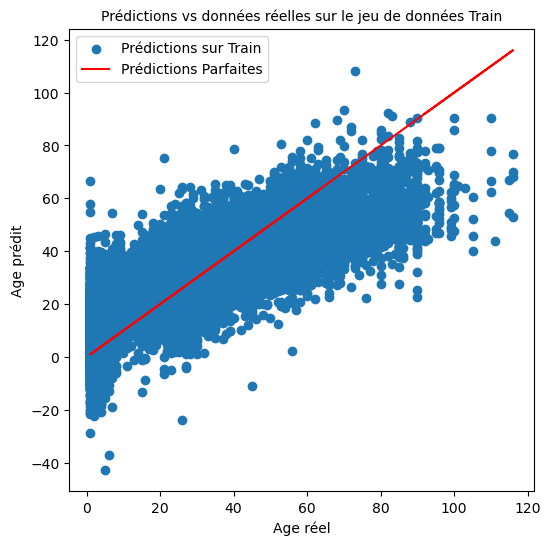

In [40]:
# Graphe des prédictions en fonction des valeurs réelles sur le jeu de données Train
plt.figure(figsize=(6, 6))
plt.scatter(y_train, grid_search.predict(X_train), label="Prédictions sur Train")
plt.plot(y_train, y_train, c="red", label="Prédictions Parfaites")
plt.legend()
plt.xlabel("Age réel")
plt.ylabel("Age prédit")
plt.title("Prédictions vs données réelles sur le jeu de données Train",fontsize=10)
plt.show()

In [41]:
# Définir les quantiles
quantiles = np.arange(0.1, 1.1, 0.1)

# Initialiser les listes pour stocker les résultats
quantile_values = []
mae_values = []
rmse_values = []

# Calculer les quantiles de y_train
y_train_quantiles = np.percentile(y_train, quantiles * 100)

# Boucle à travers chaque quantile
for i in range(len(quantiles)):
    # Sélectionner les données d'entraînement pour ce quantile
    y_train_quantile = y_train[(y_train > y_train_quantiles[i-1]) & (y_train <= y_train_quantiles[i])] if i != 0 else y_train[y_train <= y_train_quantiles[i]]
    y_train_pred_quantile = y_train_pred[(y_train > y_train_quantiles[i-1]) & (y_train <= y_train_quantiles[i])] if i != 0 else y_train_pred[y_train <= y_train_quantiles[i]]

    # Calculer MAE et RMSE
    mae = mean_absolute_error(y_train_quantile, y_train_pred_quantile)
    rmse = np.sqrt(mean_squared_error(y_train_quantile, y_train_pred_quantile))
    
    # Ajouter les valeurs aux listes
    quantile_values.append(y_train_quantiles[i])
    mae_values.append(mae)
    rmse_values.append(rmse)

# Créer un DataFrame pandas avec les résultats
results_df = pd.DataFrame({
    'Quantile': quantile_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Afficher le tableau
print(results_df)

   Quantile        MAE       RMSE
0       5.0  11.696680  14.491329
1      20.0  11.807695  13.971087
2      25.0   7.625359   9.663217
3      26.0   7.588446   9.631530
4      29.0   7.531844   9.410094
5      34.0   6.875621   8.686787
6      40.0   6.879742   8.732092
7      50.0   8.042212  10.072514
8      61.0  11.178164  13.508842
9     116.0  21.667629  24.423014


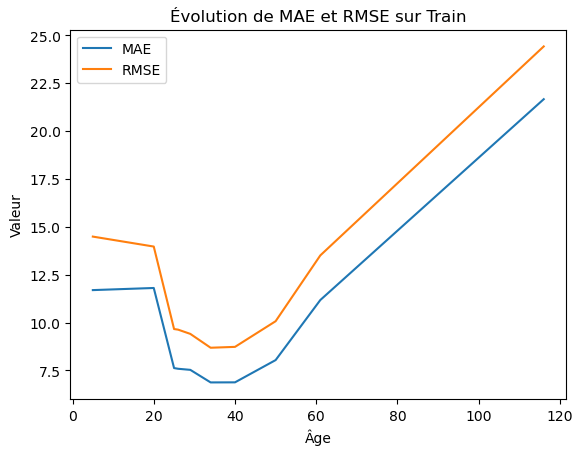

In [42]:
# Créer une figure et un axe
fig, ax = plt.subplots()

# Tracer les courbes MAE et RMSE
ax.plot(results_df['Quantile'], results_df['MAE'], label='MAE')
ax.plot(results_df['Quantile'], results_df['RMSE'], label='RMSE')

# Ajouter une légende
ax.legend()

# Ajouter des titres et des étiquettes d'axe
ax.set_title('Évolution de MAE et RMSE sur Train')
ax.set_xlabel('Âge')
ax.set_ylabel('Valeur')

# Afficher le graphique
plt.show()


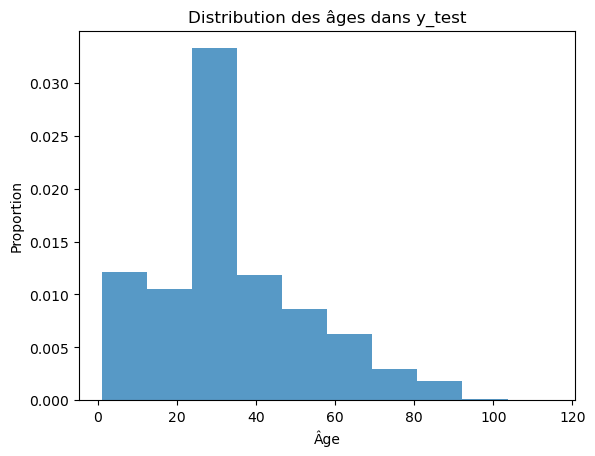

In [43]:
# Créer une figure et un axe
fig, ax = plt.subplots()
# Tracer l'histogramme des âges
ax.hist(y_test, bins=10, density=True, alpha=0.75)

# Ajouter des titres et des étiquettes d'axe
ax.set_title('Distribution des âges dans y_test')
ax.set_xlabel('Âge')
ax.set_ylabel('Proportion')

# Afficher le graphique
plt.show()

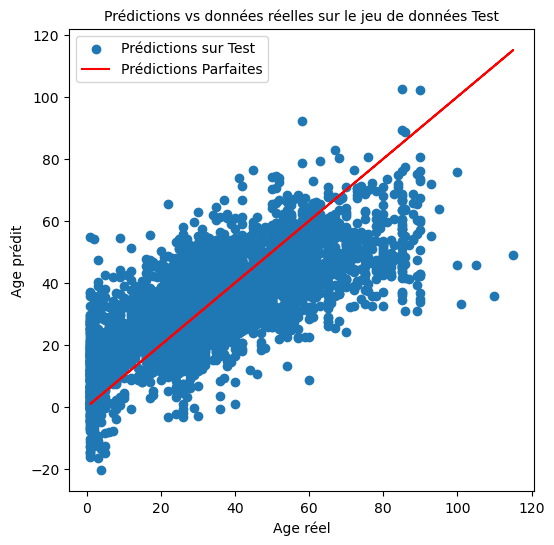

In [44]:
# Graphe des prédictions en fonction des valeurs réelles sur le jeu de données Test
plt.figure(figsize=(6, 6))
plt.scatter(y_test, grid_search.predict(X_test), label="Prédictions sur Test")
plt.plot(y_test, y_test, c="red", label="Prédictions Parfaites")
plt.legend()
plt.xlabel("Age réel")
plt.ylabel("Age prédit")
plt.title("Prédictions vs données réelles sur le jeu de données Test",fontsize=10)
plt.show()

In [45]:
# Définir les quantiles
quantiles = np.arange(0.1, 1.1, 0.1)

# Initialiser les listes pour stocker les résultats
quantile_values = []
mae_values = []
rmse_values = []

# Calculer les quantiles de y_test
y_test_quantiles = np.percentile(y_test, quantiles * 100)

# Boucle à travers chaque quantile
for i in range(len(quantiles)):
    # Sélectionner les données d'entraînement pour ce quantile
    y_test_quantile = y_test[(y_test > y_test_quantiles[i-1]) & (y_test <= y_test_quantiles[i])] if i != 0 else y_test[y_test <= y_test_quantiles[i]]
    y_test_pred_quantile = y_test_pred[(y_test > y_test_quantiles[i-1]) & (y_test <= y_test_quantiles[i])] if i != 0 else y_test_pred[y_test <= y_test_quantiles[i]]

    # Calculer MAE et RMSE
    mae = mean_absolute_error(y_test_quantile, y_test_pred_quantile)
    rmse = np.sqrt(mean_squared_error(y_test_quantile, y_test_pred_quantile))
    
    # Ajouter les valeurs aux listes
    quantile_values.append(y_test_quantiles[i])
    mae_values.append(mae)
    rmse_values.append(rmse)

# Créer un DataFrame pandas avec les résultats
results_df = pd.DataFrame({
    'Quantile': quantile_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Afficher le tableau
print(results_df)

   Quantile        MAE       RMSE
0       7.0  12.258128  15.176660
1      20.0  12.100125  14.487299
2      25.0   7.598157   9.738070
3      26.0   7.701156   9.794556
4      29.0   8.121027  10.147242
5      35.0   7.440003   9.345519
6      40.0   7.952393  10.278660
7      50.0   8.748840  11.042256
8      61.0  11.916654  14.489897
9     115.0  23.308863  26.418768


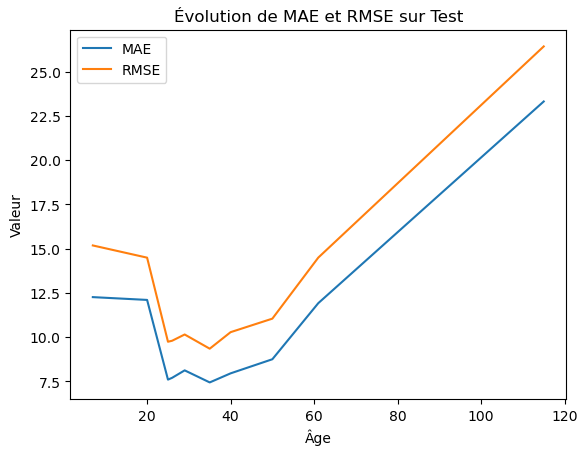

In [46]:
# Créer une figure et un axe
fig, ax = plt.subplots()

# Tracer les courbes MAE et RMSE
ax.plot(results_df['Quantile'], results_df['MAE'], label='MAE')
ax.plot(results_df['Quantile'], results_df['RMSE'], label='RMSE')

# Ajouter une légende
ax.legend()

# Ajouter des titres et des étiquettes d'axe
ax.set_title('Évolution de MAE et RMSE sur Test')
ax.set_xlabel('Âge')
ax.set_ylabel('Valeur')

# Afficher le graphique
plt.show()